# Automatic Grader with Azure OpenAI ChatGPT
This notebook can grade students’ assignments automatically by downloading them from Moodle LMS. It will unzip the assignment file from Moodle and create a folder for each student. If a student submits a zip file, it will also unzip it in their folder. The folder should contain either some Docx files or one PDF file. For Docx files, the notebook will extract and merge all the texts into one answer. For PDF files, it will only extract the text from the first page as the answer.

The notebook will then use a marking scheme as prompts and let Azure OpenAI ChatGPT evaluate the answer according to the rules. It will also estimate the probability that the answer is copied from the internet or generated by AI.

The notebook will use Azure OpenAI text-embedding-ada-002 to get the embedding of the answer. It will then use K-means clustering to group the answers based on their embeddings and show the teachers the different types of answers. It will also perform PCA on the embeddings and plot the first three principal components in 3D. This will help the teachers see how similar or different the answers are.

### Install packages

In [1]:
%pip install -q pypandoc docx2txt PyPDF2 openpyxl python-dotenv openai num2words matplotlib plotly scipy scikit-learn pandas tiktoken ipywidgets seaborn ipympl
%load_ext dotenv
%dotenv

Note: you may need to restart the kernel to use updated packages.
cannot find .env file


You should consider upgrading via the 'c:\Users\callu\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


### Common Functions

In [2]:
# read text file and return the content
def read_text_file(path):
    with open(path, 'r') as file:
        data = file.read().replace('\n', '')
    return data

def write_text_to_file(path, content):
    with open(path, 'w') as file:
        file.write(content)

Extract all submissions to a tmp folder


In [3]:
# Import the zipfile module
from zipfile import ZipFile
# Create a zip file object using ZipFile class
with ZipFile("data/submission.zip", "r") as zip_obj:
    # Extract all the files into a directory
    zip_obj.extractall("tmp/") 

In [4]:
# Import the os module
import os
import pandas as pd

# Define the path to list
temp_path = "tmp/submission/"

def is_folder_contains_file(folder_path, extension): 
    # Get a list of all files and directories in the path 
    names = os.listdir(folder_path) 
    for name in names: 
        if name.endswith(extension): 
            return True 
    return False   
    
# Get a list of all files and directories in the path
def get_submissions_df(path):
    assignment_folders = []
    names = os.listdir(path)
    # Loop through the list
    for name in names:
        # Join the path and the name
        full_path = os.path.join(path, name)
        # Check if it is a directory
        if os.path.isdir(full_path):
            # Print the directory name
            assignment_folders.append({
                "Student": name.split("_")[0],
                "Path": full_path,
                "ContainsDocxFile": is_folder_contains_file(full_path, ".docx"),                
                "ContainsPdfFile": is_folder_contains_file(full_path, ".pdf"),
                "ContainsZipFile": is_folder_contains_file(full_path, ".zip")
                })
    df = pd.DataFrame([p for p in assignment_folders])
    return df


df = get_submissions_df(temp_path)

In [5]:
df

,Student,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile
0,Callum Fry,tmp/submission/Callum Fry_2061187_assignmentsu...,True,False,False


### Ensure that all the files submitted are valid

In [6]:
def filter_df_by_not_contains_any_expected_files(df):
    return df[(df["ContainsDocxFile"] == False) & (df["ContainsPdfFile"] == False) & (df["ContainsZipFile"] == False)]
filter_df_by_not_contains_any_expected_files(df)

,Student,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile


Handle zip file.

In [7]:
import os
import shutil

def flatten(directory):
    for dirpath, _, filenames in os.walk(directory, topdown=False):
        for filename in filenames:
            i = 0
            source = os.path.join(dirpath, filename)
            target = os.path.join(directory, filename)

            while os.path.exists(target):
                i += 1
                file_parts = os.path.splitext(os.path.basename(filename))

                target = os.path.join(
                    directory,
                    file_parts[0] + "_" + str(i) + file_parts[1],
                )

            shutil.move(source, target)

            print("Moved ", source, " to ", target)

        if dirpath != directory:
            os.rmdir(dirpath)
            print("Deleted ", dirpath)

def get_first_file_path(path, ext):
    names = os.listdir(path)
    for name in names:
        if name.endswith(ext):
            return os.path.join(path, name)

def extract_zip_file_in_place(path):
    zip_path = get_first_file_path(path, ".zip")
    print(zip_path)
    import zipfile
    # Create a zip file object using ZipFile class
    with zipfile.ZipFile(zip_path, "r") as zip_obj:
        # Extract all the files into a directory
        zip_obj.extractall(path)
    flatten(path) 


def filter_df_by_contains_zip_file(df):
    return df[(df["ContainsZipFile"] == True)]

paths = filter_df_by_contains_zip_file(df)["Path"].values
for path in paths:
    extract_zip_file_in_place(path)

In [8]:
df = get_submissions_df(temp_path)
## check all rows contains Docx or PDF file
def filter_df_by_contains_docx_or_pdf_file(df):
    return df[(df["ContainsDocxFile"] == True) | (df["ContainsPdfFile"] == True)]

filter_df_by_contains_docx_or_pdf_file(df)

,Student,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile
0,Callum Fry,tmp/submission/Callum Fry_2061187_assignmentsu...,True,False,False


## Processing Docx files

In [9]:
def filter_df_by_contains_docx(df):
    return df[(df["ContainsDocxFile"] == True)]
words_df = filter_df_by_contains_docx(df)
paths = words_df["Path"].values

def get_all_docx_files(path):
    import glob
    return glob.glob(path + "/*.docx")

import docx2txt
from functools import reduce

students_words_files = list(map(get_all_docx_files, paths)) # List of lists of word files

file_contents =[];
for word_files in students_words_files:  
    file_contents.append(reduce(lambda x, y: x + y, map(lambda f: docx2txt.process(f), word_files), "\n\n"))
# reduce(map(lambda f: docx2txt.process(f), word_files), lambda x, y: x + y, "")
words_df.loc[:, "Sources"] = students_words_files
words_df.loc[:, "Answers"] = file_contents


In [10]:
def filter_df_by_contains_pdf(df):
    return df[(df["ContainsPdfFile"] == True)]
pdfs_df = filter_df_by_contains_pdf(df)
paths = pdfs_df["Path"].values

def get_add_pdf_files(path):
    import glob
    return glob.glob(path + "/*.pdf")

import PyPDF2
from functools import reduce

def convert_pdf_all_pages_to_txt(path):
    pdfFileObj = open(path, 'rb')
    reader = PyPDF2.PdfReader(pdfFileObj)
    num_pages = len(reader.pages)
    count = 0
    text = ""
    while count < num_pages:
        pageObj = reader.pages[count]
        count += 1
        text += pageObj.extract_text()
        text += "\n\n"
    return text

students_pdf_files = list(map(get_add_pdf_files, paths)) # List of lists of word files

file_contents =[];
for pdf_files in students_pdf_files:
    file_contents.append(reduce(lambda x, y: x + y, map(convert_pdf_all_pages_to_txt, pdf_files), "\n\n"))

pdfs_df.loc[:, "Sources"] = students_pdf_files
pdfs_df.loc[:, "Answers"] = file_contents
pdfs_df


,Student,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile,Sources,Answers


In [11]:
# combine two dataframes into one and export to excel
df_answers = pd.concat([words_df, pdfs_df])
df_answers.to_excel("data/answers.xlsx", index=False)

## Grading students’ responses using Azure OpenAI ChatGPT

In [16]:
import os
import json
import openai
from openai import AzureOpenAI

api_key = os.getenv("AZURE_OPENAI_API_KEY")

marking_scheme = read_text_file("marking_scheme.txt")
student_answer = df_answers.iloc[[0]]["Answers"].values[0]
prompt=marking_scheme.replace("<ANSWER></ANSWER>", student_answer)

client = AzureOpenAI(
    api_version="2023-07-01-preview",
    azure_endpoint="https://up206-m68frt2f-eastus2.cognitiveservices.azure.com/openai/deployments/gpt-35-turbo-16k/chat/completions?api-version=2024-08-01-preview",
    api_key=api_key 
)


completion = client.chat.completions.create(
    model="gpt-35-turbo-16k",  # e.g. gpt-35-instant
    messages=[
        {
            "role": "system", "content": "You are a teaching assistant.",
            "role": "user", "content": prompt,
        },
    ],
)
completion_dict = completion.model_dump()
response_content = completion_dict["choices"][0]["message"]["content"]
print(response_content)




{
    "marks": 75,
    "copyFromInternet": 0.1,
    "generativeAI": 0.5,
    "manualReview": false,
    "comments": "Great job on addressing the questions and providing a comprehensive understanding of self-efficacy in information security. Your answer is well-structured and organized, making it easy to follow. Here is the breakdown of your marks:\n\n1. What is self-efficacy in information security? - 18/20 marks\nYou have provided a clear definition of self-efficacy in information security, referencing relevant theories and research studies. However, consider adding more examples or illustrations to support your explanation.\n\n2. What impact this has on end users? - 18/20 marks\nYou have effectively explained how self-efficacy impacts end users in terms of their awareness of security threats, intentions to improve security, and vulnerability to social engineering and spyware attacks. Good use of references to support your points.\n\n3. What are the security risks for companies? - 19/

In [33]:
df_answers

,Student,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile,Sources,Answers
0,Callum Fry,tmp/submission/Callum Fry_2061187_assignmentsu...,True,False,False,[tmp/submission/Callum Fry_2061187_assignments...,\n\nStudent: 2061187\n\nSelf-Efficacy in Infor...


In [32]:
data_dict = json.loads(response_content)

# Convert the dictionary to a DataFrame
df_marked = pd.DataFrame([data_dict])


# Display the DataFrame
df_marked

,marks,copyFromInternet,generativeAI,manualReview,comments
0,75,0.1,0.5,False,Great job on addressing the questions and prov...


In [35]:
df_total = pd.concat([df_answers, df_marked], axis=1)

In [36]:
df_total

,Student,Path,ContainsDocxFile,ContainsPdfFile,ContainsZipFile,Sources,Answers,marks,copyFromInternet,generativeAI,manualReview,comments
0,Callum Fry,tmp/submission/Callum Fry_2061187_assignmentsu...,True,False,False,[tmp/submission/Callum Fry_2061187_assignments...,\n\nStudent: 2061187\n\nSelf-Efficacy in Infor...,75,0.1,0.5,False,Great job on addressing the questions and prov...


Anaylse Results: 

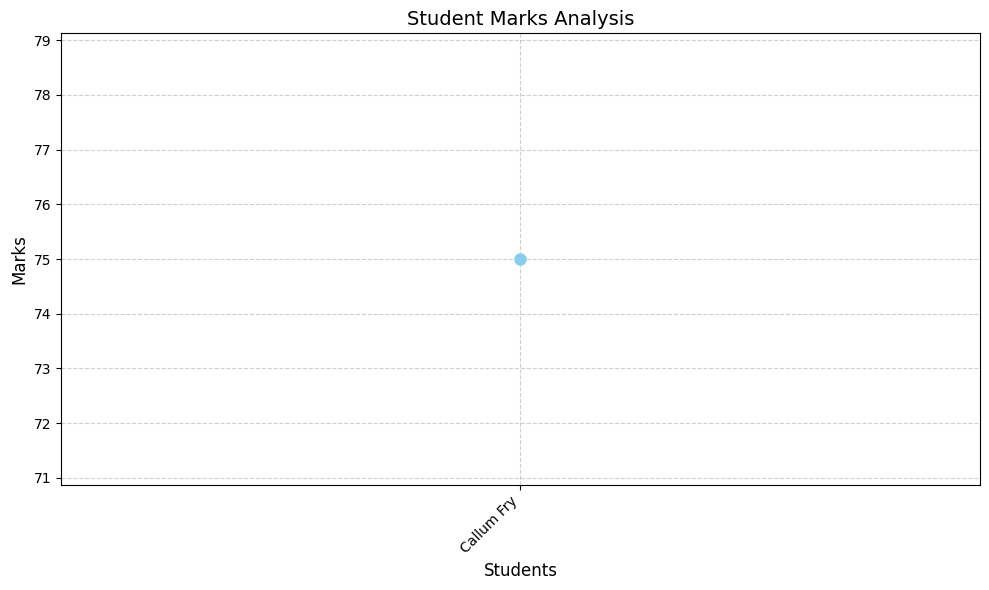

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample dataframe (replace this with your actual dataframe)
data = {
    "Student": ["Callum Fry"],
    "marks": [75],
}
df_total = pd.DataFrame(data)

# Extract the required columns
students = df_total['Student']
marks = df_total['marks']

# Create a plot chart to analyze the results
plt.figure(figsize=(10, 6))
plt.plot(students, marks, marker='o', color='skyblue', linestyle='-', linewidth=2, markersize=8)

# Add labels and title
plt.xlabel("Students", fontsize=12)
plt.ylabel("Marks", fontsize=12)
plt.title("Student Marks Analysis", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()
